In [1]:
%pylab inline
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import galsim
import galflow as gf

Populating the interactive namespace from numpy and matplotlib


## Generate a Galsim example

In [2]:
def get_ellipticity(scale_tril):
    b = tfb.FillScaleTriL(
        diag_bijector=tfb.Softplus(),
        diag_shift=None)
    
    dist = tfd.MultivariateNormalTriL(loc=[0., 0.], scale_tril=b.forward(scale_tril))

    cov = dist.covariance()
    w, v = tf.linalg.eigh(cov)
    w = tf.math.real(w)
    v = tf.math.real(v)

    x_vec = tf.constant([1., 0.])
    cosrotation = tf.tensordot(tf.transpose(x_vec), v[:,1], axes=1)/tf.norm(x_vec)/tf.norm(v[:,1])
    rotation = tf.math.acos(cosrotation)
    R = tf.convert_to_tensor([[tf.math.sin(rotation), tf.math.cos(rotation)], 
                   [-tf.math.cos(rotation), tf.math.sin(rotation)]])

    r = 10
    x = tf.math.sqrt(r * w[0]) # x-radius
    y = tf.math.sqrt(r * w[1]) # y-radius

    if x <= y:
        b = x
        a = y
    else:
        b = y
        a = x

    e_mod = (1-b/a)/(1+b/a)
    e1 = e_mod*tf.math.cos(2*rotation)
    e2 = e_mod*tf.math.sin(2*rotation)
    
    return tf.convert_to_tensor([tf.math.abs(e1), tf.math.abs(e2)])
    #return e1

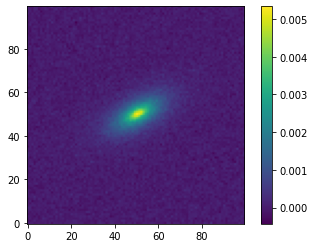

In [3]:
gal_flux = 1.    # counts
gal_r0 = 1.      # arcsec
pixel_scale = 0.2  # arcsec / pixel
N = 100            # image width/height

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=N,ny=N, scale=pixel_scale),
                               x_interpolant='linear')

imgal = gal.drawImage(nx=N, ny=N, scale=pixel_scale,
                      method='no_pixel',use_true_center=False)

imgal = imgal.array.reshape(1,N,N,1)
imgal = tf.convert_to_tensor(imgal, dtype=tf.float32)

g1 = 0.2
g2 = 0.3
g1 = tf.reshape(tf.convert_to_tensor(g1, dtype=tf.float32), [-1])
g2 = tf.reshape(tf.convert_to_tensor(g2, dtype=tf.float32), [-1])

imgal = gf.shear(imgal, g1, g2)

im = imgal[0,...,0] + 0.0001*tf.random.normal([N,N])
imshow(im, origin='lower')
colorbar()

In [4]:
#import numpy as np
#np.save('im_test', im.numpy())

In [5]:
coords = tf.stack(tf.meshgrid(tf.range(-N/2,N/2), tf.range(-N/2,N/2)), axis=-1).numpy()

In [6]:
def model(tril_params):
  b = tfb.FillScaleTriL(
     diag_bijector=tfb.Softplus(),
     diag_shift=None)
  dist = tfd.MultivariateNormalTriL(loc=[0.,0.], 
                                    scale_tril=b.forward(x=tril_params))
  return dist.prob(coords)

In [7]:
# Let's test it out
params = tf.ones(3)*5
x = model(params)

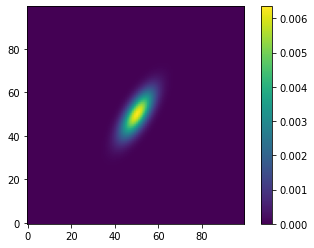

In [8]:
imshow(x, origin='lower')
colorbar()

In [9]:
loss = lambda x, p: tf.reduce_sum((x - model(p))**2)

In [10]:
def f(x, z):
  with tf.GradientTape() as g:
    g.watch(z)
    l = loss(x, z)
  
  grad = g.gradient(l, z)
  #print(grad)
  return z - 10. * grad

In [11]:
#def _f(z):
#    return f(im, z)

In [12]:
@tf.function()#experimental_compile=True
def fwd_solver(f, z_init):
  def cond_fun(z_prev, z):
    #z_prev, z = carry
    return tf.less(tf.constant(1e-5), tf.norm(z_prev - z))

  def body_fun(z_prev, z):
    #_, z = carry
    return z, f(z)

  _, z_star = tf.while_loop(cond_fun, body_fun, loop_vars=[z_init, f(z_init)], maximum_iterations=int(1e5))
  return z_star

In [13]:
z_star = fwd_solver(lambda z: f(im, z), tf.ones(3)) 

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [14]:
get_ellipticity(z_star)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.19753633, 0.3003325 ], dtype=float32)>

## Measure ellipticity with implicit layers

In [15]:
@tf.custom_gradient
def fixed_point_layer_implicit(im):
  # Find the fixed point
  params = tf.ones(3)
  z_star = fwd_solver(lambda z: f(im, z), params)
  z_star1 = tf.identity(z_star)

  # Comput the custom gradient
  with tf.GradientTape() as tape1:
    tape1.watch(z_star)
    f_star = f(im, z_star)
  g1 = tape1.jacobian(f_star, z_star)

  with tf.GradientTape() as tape0:
    tape0.watch(im)
    f_star = f(im, z_star1)
  g0 = tape0.jacobian(f_star, im)
  
  def grad(upstream):
    dz_da = tf.tensordot(tf.linalg.inv(tf.eye(3) - g1), g0, axes=1)
    return tf.tensordot(upstream, dz_da, axes=1)
    
  return z_star, grad

In [16]:
def get_ellipticity_implicit(img):
    z_star = fixed_point_layer_implicit(img)
    return get_ellipticity(z_star)

In [17]:
#get_ellipticity_implicit(im)

## Compute gradients w.r.t inputs

In [18]:
with tf.GradientTape() as g:
  g.watch(im)
  end = get_ellipticity_implicit(im)
  #end = (lambda x: tf.reduce_sum(fixed_point_layer_implicit(x)))(im)
  #end = tf.reduce_sum(fixed_point_layer_implicit(im))

grad2 = g.jacobian(end, im)
grad2.shape

TensorShape([2, 100, 100])

Text(0.5, 1.0, 'gradient of e2 w.r.t. input')

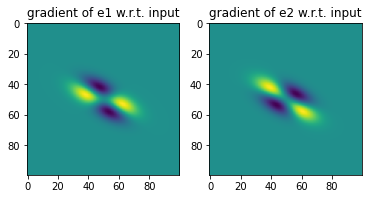

In [19]:
subplot(121)
imshow(grad2[0,...])
title('gradient of e1 w.r.t. input')

subplot(122)
imshow(grad2[1,...])
title('gradient of e2 w.r.t. input')

## With higher input noise

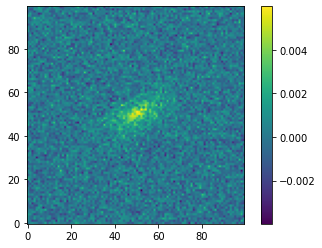

In [21]:
gal_flux = 1.    # counts
gal_r0 = 1.      # arcsec
pixel_scale = 0.2  # arcsec / pixel
N = 100            # image width/height

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)
# To make sure that GalSim is not cheating, i.e. using the analytic formula of the light profile
# when computing the affine transformation, it might be a good idea to instantiate the image as
# an interpolated image.
# We also make sure GalSim is using the same kind of interpolation as us (bilinear for TF)
gal = galsim.InterpolatedImage(gal.drawImage(nx=N,ny=N, scale=pixel_scale),
                               x_interpolant='linear')

imgal = gal.drawImage(nx=N, ny=N, scale=pixel_scale,
                      method='no_pixel',use_true_center=False)

imgal = imgal.array.reshape(1,N,N,1)
imgal = tf.convert_to_tensor(imgal, dtype=tf.float32)

g1 = 0.2
g2 = 0.3
g1 = tf.reshape(tf.convert_to_tensor(g1, dtype=tf.float32), [-1])
g2 = tf.reshape(tf.convert_to_tensor(g2, dtype=tf.float32), [-1])

imgal = gf.shear(imgal, g1, g2)

im = imgal[0,...,0] + 0.001*tf.random.normal([N,N])
imshow(im, origin='lower')
colorbar()

In [23]:
with tf.GradientTape() as g:
  g.watch(im)
  end = get_ellipticity_implicit(im)
  #end = (lambda x: tf.reduce_sum(fixed_point_layer_implicit(x)))(im)
  #end = tf.reduce_sum(fixed_point_layer_implicit(im))

grad2 = g.jacobian(end, im)
grad2.shape

TensorShape([2, 100, 100])

In [24]:
# ellipticiries
end

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.21377027, 0.30070937], dtype=float32)>

Text(0.5, 1.0, 'gradient of e2 w.r.t. input')

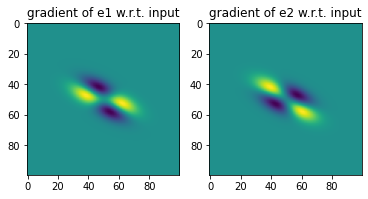

In [25]:
# gradients
subplot(121)
imshow(grad2[0,...])
title('gradient of e1 w.r.t. input')

subplot(122)
imshow(grad2[1,...])
title('gradient of e2 w.r.t. input')